In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.



In [1]:
%%capture
!pip install datasets>=2.18.0 transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

**Data**

In [2]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

**Supervised** **Classification**

HuggingFace Trainer

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Tokenize our data.

In [4]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Define metrics.

In [5]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

Train model.

In [6]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-6-8f6c5e3dde62>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
trainer.train()

Step,Training Loss
500,0.405800


TrainOutput(global_step=534, training_loss=0.40266278799107014, metrics={'train_runtime': 115.7233, 'train_samples_per_second': 73.71, 'train_steps_per_second': 4.614, 'total_flos': 227605451772240.0, 'train_loss': 0.40266278799107014, 'epoch': 1.0})

Evaluate results.

In [8]:
trainer.evaluate()

{'eval_loss': 0.3628309369087219,
 'eval_f1': 0.8534080298786181,
 'eval_runtime': 3.9061,
 'eval_samples_per_second': 272.903,
 'eval_steps_per_second': 17.152,
 'epoch': 1.0}

Freeze Layers

In [9]:
# Load Model and Tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [11]:
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

In [12]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
     print(f"Parameter: {name} ----- {param.requires_grad}")

Parameter: bert.embeddings.word_embeddings.weight ----- False
Parameter: bert.embeddings.position_embeddings.weight ----- False
Parameter: bert.embeddings.token_type_embeddings.weight ----- False
Parameter: bert.embeddings.LayerNorm.weight ----- False
Parameter: bert.embeddings.LayerNorm.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: bert.encoder.layer.0.attention.output

In [13]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-13-1da7f8eeebcf>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694700


TrainOutput(global_step=534, training_loss=0.6948552721002129, metrics={'train_runtime': 32.9544, 'train_samples_per_second': 258.842, 'train_steps_per_second': 16.204, 'total_flos': 227605451772240.0, 'train_loss': 0.6948552721002129, 'epoch': 1.0})

In [14]:
trainer.evaluate()

{'eval_loss': 0.6825135946273804,
 'eval_f1': 0.64,
 'eval_runtime': 3.7947,
 'eval_samples_per_second': 280.917,
 'eval_steps_per_second': 17.656,
 'epoch': 1.0}

# Freeze blocks 1-5

In [15]:
# We can check whether the model was correctly updated
for index, (name, param) in enumerate(model.named_parameters()):
     print(f"Parameter: {index}{name} ----- {param.requires_grad}")

Parameter: 0bert.embeddings.word_embeddings.weight ----- False
Parameter: 1bert.embeddings.position_embeddings.weight ----- False
Parameter: 2bert.embeddings.token_type_embeddings.weight ----- False
Parameter: 3bert.embeddings.LayerNorm.weight ----- False
Parameter: 4bert.embeddings.LayerNorm.bias ----- False
Parameter: 5bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: 6bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: 7bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: 8bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: 9bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: 10bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: 11bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: 12bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: 13bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: 14bert.encoder.laye

In [16]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 10 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-389edc8581b7>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.476100


{'eval_loss': 0.4100644588470459,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 3.7268,
 'eval_samples_per_second': 286.032,
 'eval_steps_per_second': 17.978,
 'epoch': 1.0}

# [BONUS] Freeze blocks

In [17]:
scores = []
for index in range(12):
    # Re-load model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # Freeze encoder blocks 0-index
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # Train
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # Evaluate
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.405500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.408100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.411300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.415100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.421800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.430100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.446200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.472200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.518100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-64e61e26465d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.655600


In [18]:
scores

[0.8504672897196262,
 0.8541862652869238,
 0.8528584817244611,
 0.8466603951081844,
 0.8388312912346843,
 0.839134524929445,
 0.8434864104967198,
 0.8358490566037736,
 0.8258801141769743,
 0.8164435946462715,
 0.7925270403146509,
 0.7058823529411765]

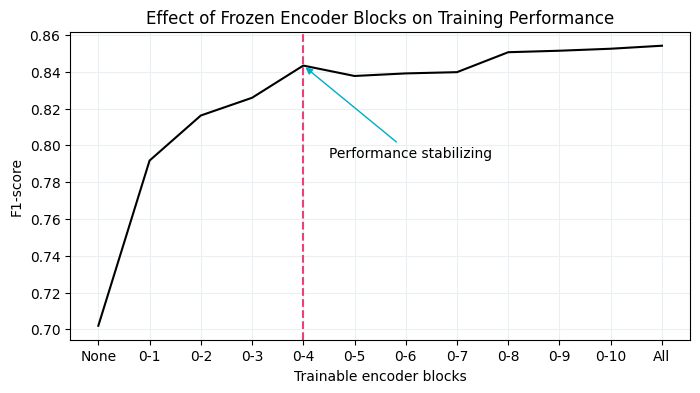

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create Figure
plt.figure(figsize=(8,4))

# Prepare Data
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = [
    0.8541862652869239,
    0.8525519848771267,
    0.8514664143803217,
    0.8506616257088847,
    0.8398104265402844,
    0.8391345249294448,
    0.8377358490566037,
    0.8433962264150944,
    0.8258801141769743,
    0.816247582205029,
    0.7917485265225934,
    0.7019400352733686
][::-1]

# Stylize Figure
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# Plot Data
plt.plot(x, y, color="black")

# Additional Annotation
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

# Few-shot Classification

In [20]:
from setfit import sample_dataset

# We simulate a few-shot setting by sampling 16 examples per class
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [21]:
from setfit import SetFitModel

# Load a pre-trained SentenceTransformer model
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [22]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# Define training arguments
args = SetFitTrainingArguments(
    num_epochs=3, # The number of epochs to use for contrastive learning
    num_iterations=20  # The number of text pairs to generate
)
args.eval_strategy = args.evaluation_strategy

# Create trainer
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [23]:
from setfit import SetFitTrainer

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1",
    num_epochs=3, # The number of epochs to use for contrastive learning
)

<ipython-input-23-8076ddfca303>:4: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [24]:
# Training loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harshgharat99 (harshgharat99-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
1,0.308300
50,0.118500
100,0.001100
150,0.000400
200,0.000300


In [25]:
# Evaluate the model on our test data
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.845703125}

In [26]:
model.model_head

LogisticRegression()

# MLM

In [27]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model for Masked Language Modeling (MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

In [28]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Tokenize data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [29]:
from transformers import DataCollatorForLanguageModeling

# Masking Tokens
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [30]:
from transformers import DataCollatorForWholeWordMask

# Masking Whole Words
data_collator = DataCollatorForWholeWordMask(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [31]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-31-49b50980f408>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [32]:
# Save pre-trained tokenizer
tokenizer.save_pretrained("mlm")

# Train model
trainer.train()

# Save updated model
model.save_pretrained("mlm")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
500,3.115200
1000,2.913200
1500,2.826500
2000,2.721600
2500,2.645100
3000,2.626300
3500,2.574200
4000,2.519800
4500,2.520300
5000,2.481200


In [33]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [34]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> What a horrible movie!
>>> What a horrible mess!
>>> What a horrible film!
>>> What a horrible idea!
>>> What a horrible story!


# Named Entity Recognition
Here are a number of interesting datasets you can also explore for NER:

tner/mit_movie_trivia
tner/mit_restaurant
wnut_17
conll2003

In [34]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [35]:
# The CoNLL-2003 dataset for NER
dataset = load_dataset("conll2003", trust_remote_code=True)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [36]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [37]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [38]:
from transformers import AutoModelForTokenClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Split individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

In [40]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # Map tokens to their respective word
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # The start of a new word
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # Special token is -100
            elif word_idx is None:
                label_ids.append(-100)

            # If the label is B-XXX we change it to I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [41]:
# Difference between original and updated labels
print(f"Original: {example['ner_tags']}")
print(f"Updated: {tokenized['train'][848]['labels']}")

Original: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [42]:
import evaluate

# Load sequential evaluation
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # Create predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # Document-level iteration
    for prediction, label in zip(predictions, labels):

      # token-level iteration
      for token_prediction, token_label in zip(prediction, label):

        # We ignore special tokens
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [43]:
from transformers import DataCollatorForTokenClassification

# Token-classification Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [44]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-44-1f83315717f5>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.229900


TrainOutput(global_step=878, training_loss=0.1667890396639535, metrics={'train_runtime': 172.7704, 'train_samples_per_second': 81.27, 'train_steps_per_second': 5.082, 'total_flos': 351240792638148.0, 'train_loss': 0.1667890396639535, 'epoch': 1.0})

In [45]:
# Evaluate the model on our test data
trainer.evaluate()

{'eval_loss': 0.1546512246131897,
 'eval_f1': 0.9009982832072232,
 'eval_runtime': 10.6037,
 'eval_samples_per_second': 325.641,
 'eval_steps_per_second': 20.37,
 'epoch': 1.0}

In [47]:
from transformers import pipeline

# Save our fine-tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Harsh.")


Device set to use cuda:0


[{'entity': 'B-PER',
  'score': 0.97512305,
  'index': 4,
  'word': 'Ha',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.94192827,
  'index': 5,
  'word': '##rs',
  'start': 13,
  'end': 15},
 {'entity': 'I-PER',
  'score': 0.912999,
  'index': 6,
  'word': '##h',
  'start': 15,
  'end': 16}]